In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import sys
sys.path.insert(1, "../..")
from simulations import newtons_cooling_law
from itertools import product
from prototype_nn import Splitting, predictions, tensor_flatten
import matplotlib.pyplot as plt
import prototype
import torch
%run ../utilities.ipynb

## Training : Simulations

In [2]:
training = pd.DataFrame(data = pd.read_csv("../../data/train/newtons_cooling_law.csv", usecols=[0,1,2]))
training.head()

,time,temp,initial_temp
0,0,1.000000,1
1,1,1.312649,1
2,2,1.620644,1
3,3,1.924053,1
4,4,2.222945,1


### Dataframe

In [3]:
len(training)

12000

In [4]:
initial = training[training["initial_temp"] == 1]

<AxesSubplot:xlabel='time', ylabel='temp'>

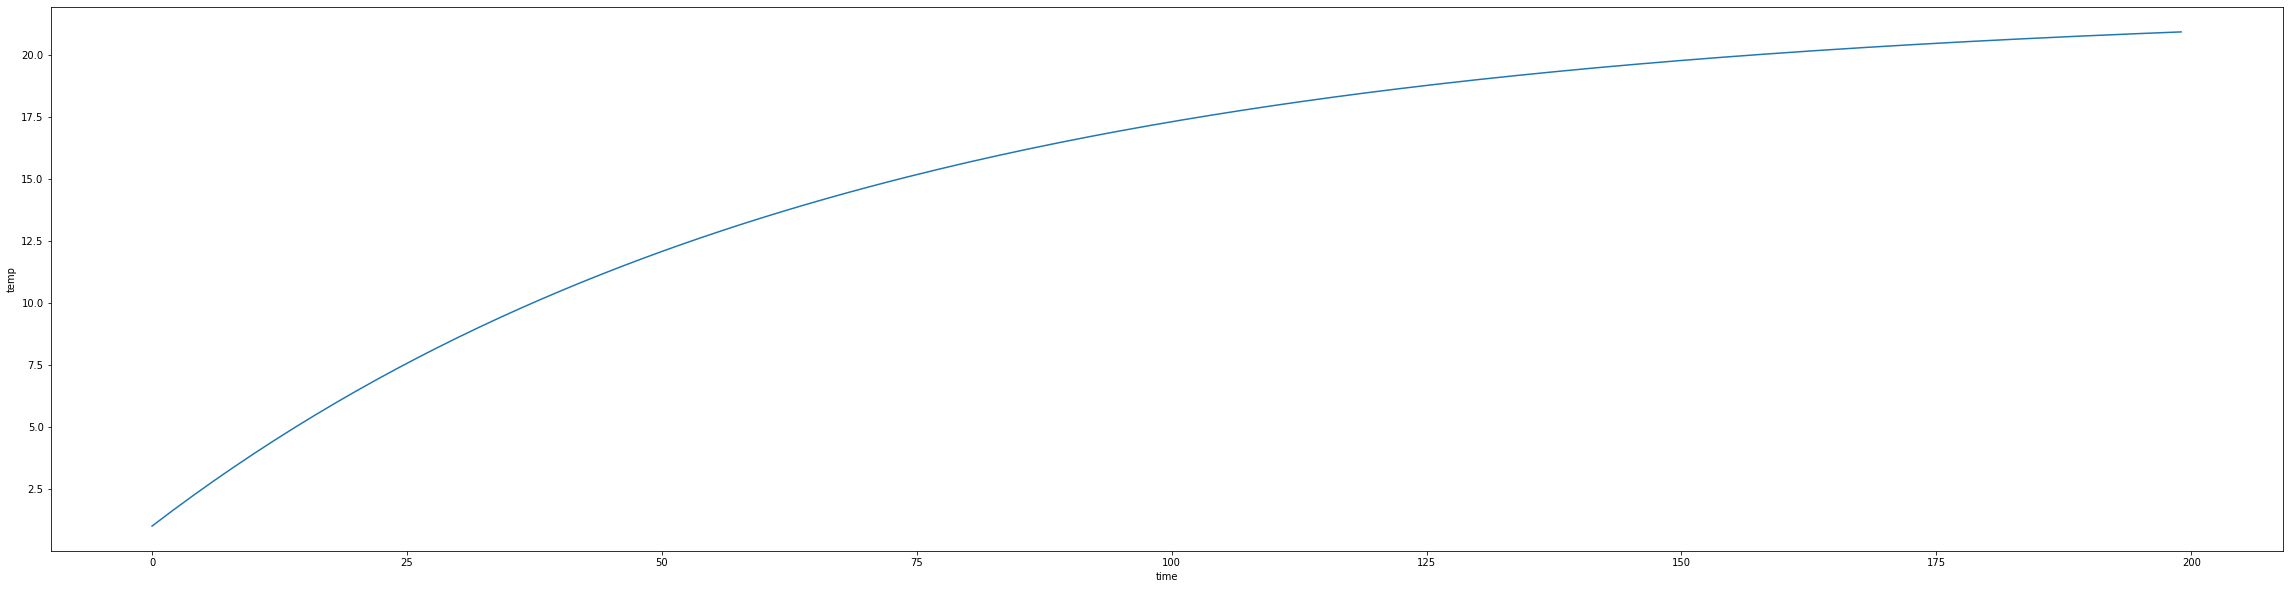

In [5]:
fig, ax = plt.subplots(ncols=1, figsize=(40,10))
sns.lineplot(data = initial, x = "time", y = "temp", ax=ax)

In [6]:
# lr = 0.0001, bs = 50, ts = 1, epoch = 20
kfold = Splitting([0,2], [1], num_epoches = 30, batch_size = 32, lr= 0.0001)

In [7]:
evaluate = kfold.cross_validation_evaluate(training, 5)

------------- Fold 0 -------------
TEST: 0 TRAIN: [1, 2, 3, 4]
Epoch: 0  Train Loss: 17.24005889892578 
Epoch: 1  Train Loss: 18.627567291259766 
Epoch: 2  Train Loss: 19.925142288208008 
Epoch: 3  Train Loss: 15.357797622680664 
Epoch: 4  Train Loss: 10.26101303100586 
Epoch: 5  Train Loss: 8.564998626708984 
Epoch: 6  Train Loss: 3.4249465465545654 
Epoch: 7  Train Loss: 2.232823371887207 
Epoch: 8  Train Loss: 0.9766983389854431 
Epoch: 9  Train Loss: 0.6871479749679565 
Epoch: 10  Train Loss: 0.2665480971336365 
Epoch: 11  Train Loss: 0.10038147866725922 
Epoch: 12  Train Loss: 0.0750335231423378 
Epoch: 13  Train Loss: 0.11663539707660675 
Epoch: 14  Train Loss: 0.07525023072957993 
Epoch: 15  Train Loss: 0.06782100349664688 
Epoch: 16  Train Loss: 0.0483316108584404 
Epoch: 17  Train Loss: 0.05384671688079834 
Epoch: 18  Train Loss: 0.01807761751115322 
Epoch: 19  Train Loss: 0.02807682752609253 
Epoch: 20  Train Loss: 0.011013828217983246 
Epoch: 21  Train Loss: 0.01990194432437

In [8]:
evaluate

[tensor(0.0780, grad_fn=<MseLossBackward>),
 tensor(0.0092, grad_fn=<MseLossBackward>),
 tensor(0.0365, grad_fn=<MseLossBackward>),
 tensor(0.0146, grad_fn=<MseLossBackward>),
 tensor(0.0486, grad_fn=<MseLossBackward>)]

In [9]:
average_loss = 0
for x in evaluate:
    average_loss += x.item()
average_loss/len(evaluate)

0.037401994504034516

## Training_set : Predictions

In [10]:
training_predictions = pd.DataFrame(data=pd.read_csv("../../data/preds/train/newtons_cooling_law.csv"))
training_predictions.head()

,initial_temp,time,temp
0,1,0,1.017763
1,1,1,1.297255
2,1,2,1.475456
3,1,3,1.974566
4,1,4,2.364241


In [11]:
training_predictions = training_predictions.rename(columns = {"temp" : "preds_temps"})

In [12]:
training_predictions.head()

,initial_temp,time,preds_temps
0,1,0,1.017763
1,1,1,1.297255
2,1,2,1.475456
3,1,3,1.974566
4,1,4,2.364241


In [13]:
training_and_predictions = training_predictions.merge(training.drop(columns = ["time", "initial_temp"]), right_index = True, left_index = True)

In [14]:
training_and_predictions.head()

,initial_temp,time,preds_temps,temp
0,1,0,1.017763,1.000000
1,1,1,1.297255,1.312649
2,1,2,1.475456,1.620644
3,1,3,1.974566,1.924053
4,1,4,2.364241,2.222945


In [15]:
def hue(df):
    columns = list(df.columns)
    columns.remove("temp")
    columns.remove("preds_temps")
    df = df.melt(columns, var_name='preds/simulations', value_name='temps')
    return df

## Graphs

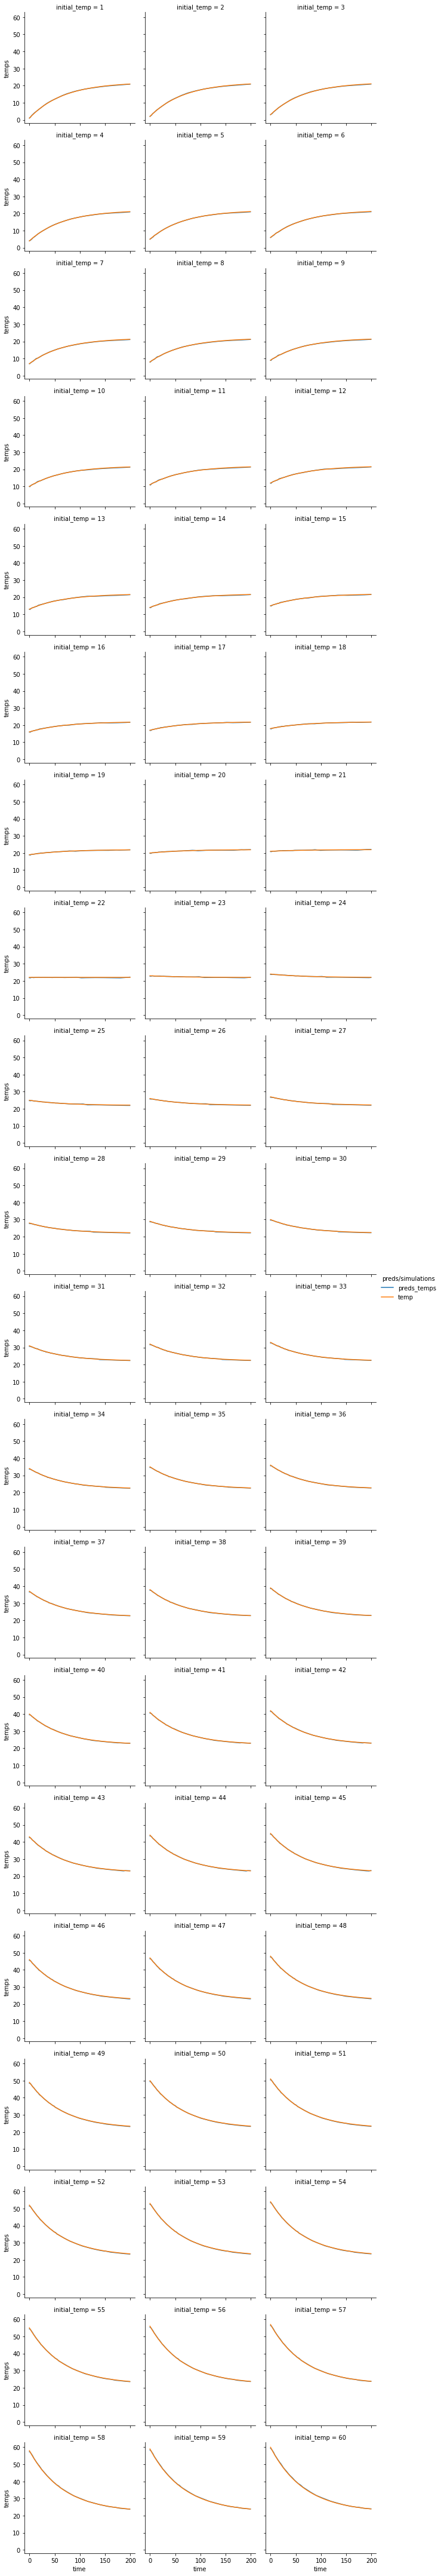

In [16]:
g = sns.FacetGrid(hue(training_and_predictions), col="initial_temp", hue = "preds/simulations", col_wrap=3,)
g.map(sns.lineplot, "time", "temps", ci=None)
g.add_legend()

## Testing : Simulations

In [53]:
testing = newtons_cooling_law(delta = 1, simulations = 200 , save = False, initial_paras = np.random.uniform(0, 61, 30))

In [54]:
testing.head()

,time,temp,initial_temp
0,0,52.942624,52.942624
1,1,52.481948,52.942624
2,2,52.028132,52.942624
3,3,51.581071,52.942624
4,4,51.140667,52.942624


In [55]:
len(testing)

6000

In [56]:
def testing_preds(test_df):
    inputs = torch.tensor(test_df.iloc[ :, [0,2]].values)
    targets = torch.tensor(test_df.iloc[:, [1]].values)
    preds, _ = predictions(num_inputs=2, num_classes=1, learning_rate=0.0005, batch_size=1, num_epochs=1, inputs=inputs.float(), targets=targets.float(), train=False, path= "../../data/state/newtons_cooling_law.pth")
    data = {'time' : test_df.time.values,
            'initial_temp' : test_df.initial_temp.values,
            'temp' : tensor_flatten(preds[:,0])}
    return pd.DataFrame(data = data, columns = ["time", "temp", "initial_temp"]);

In [57]:
testing_predictions = testing_preds(testing)
testing_predictions = testing_predictions.rename(columns = {"temp" : "preds_temps"})

In [58]:
testing_predictions.head()

,time,preds_temps,initial_temp
0,0,52.341019,52.942624
1,1,52.347435,52.942624
2,2,52.106487,52.942624
3,3,51.695808,52.942624
4,4,51.257019,52.942624


In [59]:
len(testing_predictions)

6000

In [60]:
testing_and_predictions = testing.merge(testing_predictions, right_on = ["time", "initial_temp"], left_on = ["time", "initial_temp"])
#training_and_predictions = training_predictions.merge(training.drop(columns = ["time", "initial_temp"]), right_index = True, left_index = True)

In [61]:
testing_and_predictions.head()

,time,temp,initial_temp,preds_temps
0,0,52.942624,52.942624,52.341019
1,1,52.481948,52.942624,52.347435
2,2,52.028132,52.942624,52.106487
3,3,51.581071,52.942624,51.695808
4,4,51.140667,52.942624,51.257019


In [62]:
len(testing_and_predictions)

6000

## Graphs

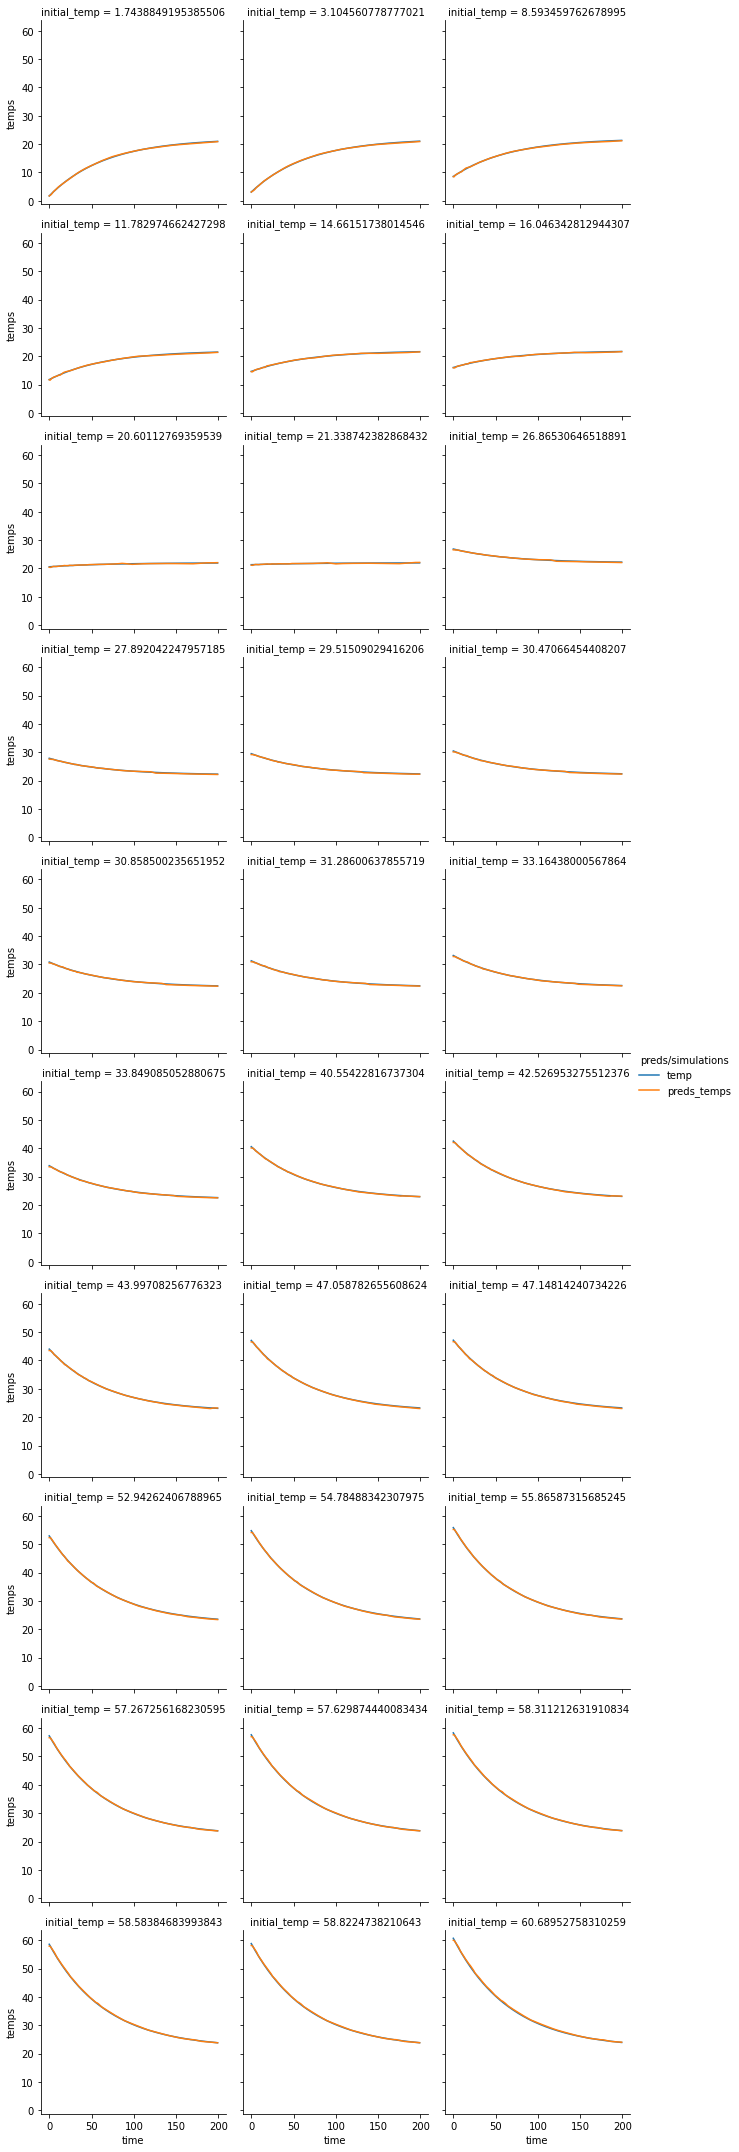

In [63]:
g = sns.FacetGrid(hue(testing_and_predictions), col="initial_temp", hue = "preds/simulations", col_wrap=3,)
g.map(sns.lineplot, "time", "temps", ci=None)
g.add_legend()

### Loss by simulation

This section is looking at the loss for each simulation

In [64]:
testing_cpy = testing

In [65]:
testing_predictions_cpy = testing_predictions

These are the dataframes we are using:
    <ol>
    <li> testing_cpy - holds the testing simulation data </li>
    <li> testing_predictions_cpy - hold the prediction fo the testing simulation data </li>
    </ol>

In [66]:
testing_cpy['initial_parameters'] = list(zip(testing_cpy.initial_temp))
testing_predictions_cpy['initial_parameters'] = list(zip(testing_predictions_cpy.initial_temp))

In [67]:
testing_cpy.head()

,time,temp,initial_temp,initial_parameters
0,0,52.942624,52.942624,"(52.94262406788965,)"
1,1,52.481948,52.942624,"(52.94262406788965,)"
2,2,52.028132,52.942624,"(52.94262406788965,)"
3,3,51.581071,52.942624,"(52.94262406788965,)"
4,4,51.140667,52.942624,"(52.94262406788965,)"


In [68]:
testing_predictions_cpy.head()

,time,preds_temps,initial_temp,initial_parameters
0,0,52.341019,52.942624,"(52.94262406788965,)"
1,1,52.347435,52.942624,"(52.94262406788965,)"
2,2,52.106487,52.942624,"(52.94262406788965,)"
3,3,51.695808,52.942624,"(52.94262406788965,)"
4,4,51.257019,52.942624,"(52.94262406788965,)"


The lossBySimulation function provides us with a loss for each individual simulation

In [69]:
simulationLoss, _ = lossBySimulations(testing_cpy, testing_predictions_cpy, [1])

This is the simulationLoss is dataframe showing the simulation and the correpsonding loss

In [70]:
simulationLoss.head()

,initial_parameters,Loss
0,1.7438849195385506,0.014924
1,3.104560778777021,0.013034
2,8.593459762678995,0.015890
3,11.782974662427298,0.019204
4,14.66151738014546,0.014066


This is demonstrating the graph for each simulation

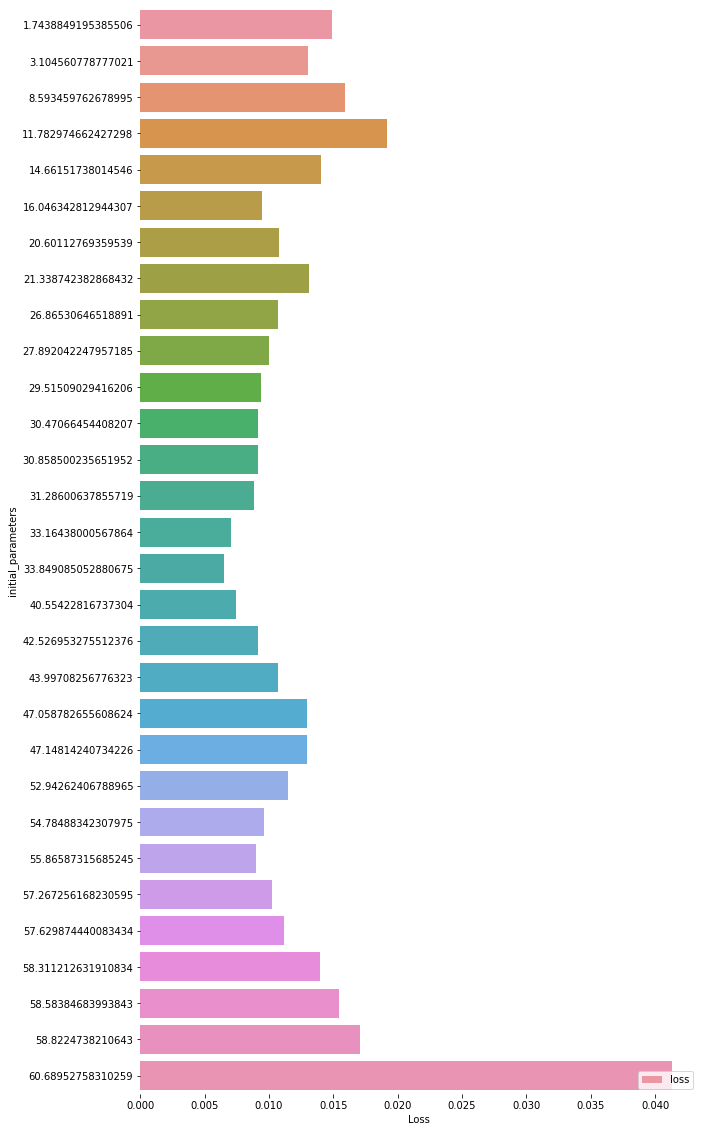

In [71]:
simulaPlots("Loss", "initial_parameters", simulationLoss, figsize = (10, 20))

This lossByTime function has the loss at each individual time within a simulation

In [72]:
timeLoss, _ = lossByTime(testing_cpy, testing_predictions_cpy, [1])

This timeLoss dataframe shows the loss corresponding to an individual time step for a specified simulation

In [73]:
timeLoss.head()

,Time,initial_parameters,Loss
0,0,"(1.7438849195385506,)",6.791306e-07
1,1,"(1.7438849195385506,)",7.879209e-03
2,2,"(1.7438849195385506,)",3.176510e-02
3,3,"(1.7438849195385506,)",2.225259e-02
4,4,"(1.7438849195385506,)",1.664278e-03


This data is shown on a graphs

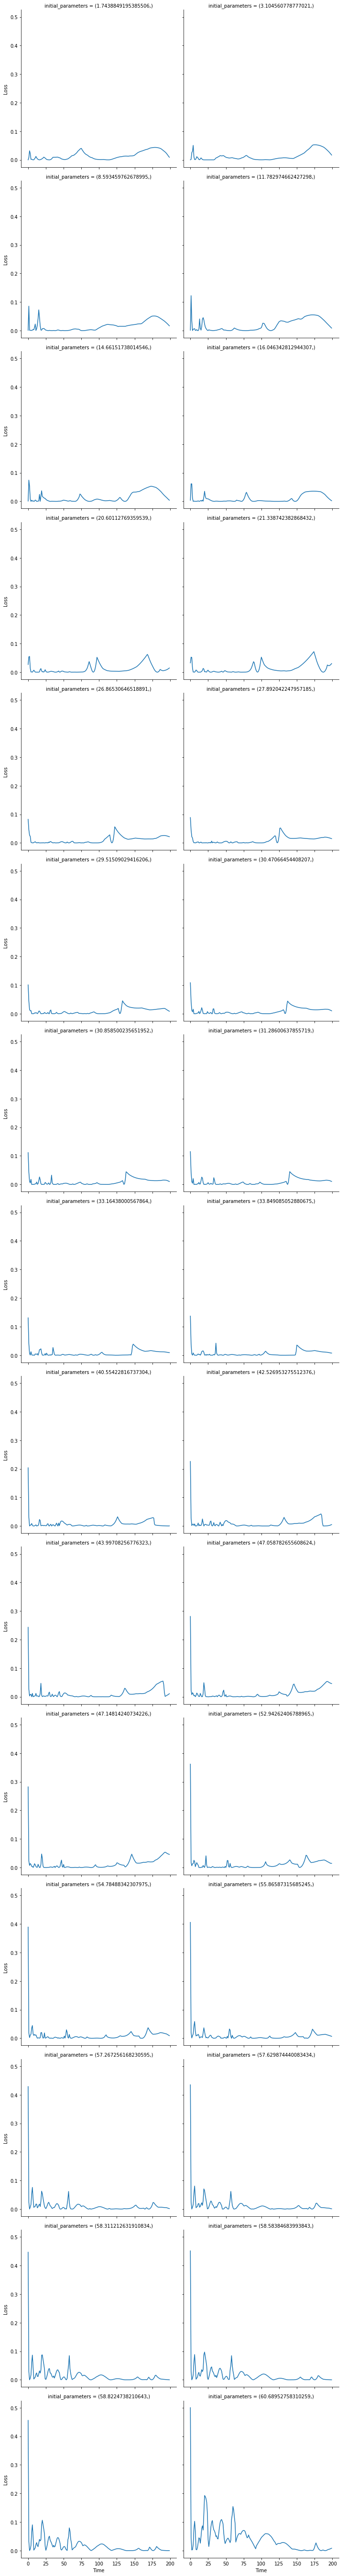

In [74]:
g = sns.FacetGrid(data = timeLoss, col = "initial_parameters" , height = 5, col_wrap=2)
g.map(sns.lineplot, "Time", "Loss", ci=None)
g.add_legend()